In [61]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
from Bio import SeqIO

import numpy as np
import pandas as pd
import pickle as pk
import torch
import warnings

from tqdm.notebook import tqdm
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BASE_DIR = ".."
sys.path.append(BASE_DIR)

In [57]:
surfaceome_db = pd.read_csv('/afs/csail/u/s/samsl/Work/databases/surfaceome/surfaceome_merged_db.tsv',sep='\t')
surfaceome_db = surfaceome_db.dropna(subset = ["UniProt gene"])
surfaceome_fasta = SeqIO.to_dict(SeqIO.parse("/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_seqs.fasta","fasta"))

with open("/afs/csail/u/s/samsl/Work/Adapting_PLM_DTI/dataset/assayable_kinases.txt","r") as f:
    assayable_kinases = [l.strip() for l in f]
    
kinase_db = surfaceome_db[surfaceome_db["UniProt gene"].isin(assayable_kinases)][["UniProt gene", "Sequence"]]
kinase_db = kinase_db.sort_values(by="UniProt gene")

In [93]:
dude_missing_list = list(set(assayable_kinases).difference(surfaceome_db["UniProt gene"]))

# AKT2 = 3D0E
# SRC = 3EL8
# ROCK1 = 2ETR
dude_missing_seqs = [
    "KVTMNDFDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHTVTESRVLQNTRHPFLTALKYAFQTHDRLCFVMEYANGGELFFHLSRERVFTEERARFYGAEIVSALEYLHSRDVVYRDIKLENLMLDKDGHIKITDFGLCKEGISDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHERLFELILMEEIRFPRTLSPEAKSLLAGLLKKDPKQRLGGGPSDAKEVMEHRFFLSINWQDVVQKKLLPPFKPQVTSEVDTRYFDDEFTAQSITITPPDRYDSLGLLELDQRTHFPQFDYSASIR",
    "GHMQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGEMGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKDPEERPTFEYLQAFLEDYFTSTEPQYQPGENL",
    "GSLHMSFETRFEKMDNLLRDPKSEVNSDCLLDGLDALVYDLDFPALRKNKNIDNFLSRYKDTINKIRDLRMKAEDYEVVKVIGRGAFGEVQLVRHKSTRKVYAMKLLSKFEMIKRSDSAFFWEERDIMAFANSPWVVQLFYAFQDDRYLYMVMEYMPGGDLVNLMSNYDVPEKWARFYTAEVVLALDAIHSMGFIHRDVKPDNMLLDKSGHLKLADFGTCMKMNKEGMVRCDTAVGTPDYISPEVLKSQGGDGYYGRECDWWSVGVFLYEMLVGDTPFYADSLVGTYSKIMNHKNSLTFPDDNDISKEAKNLICAFLTDREVRLGRNGVEEIKRHLFFKNDQWAWETLRDTVAPVVPDLSSDIDTSNFDDLEEDKGEEETFPIPKAFVGNQLPFVGFTYYSNRRYLSSANPNDNR"
]

dude_nonsurface = pd.DataFrame({
    "UniProt gene": dude_missing_list,
    "Sequence": dude_missing_seqs
})

kinase_db = pd.concat([kinase_db, dude_nonsurface])
kinase_db = kinase_db.sort_values(by="UniProt gene").reset_index(drop = True)

In [227]:
cayman_db = pd.read_csv('/afs/csail/u/s/samsl/Work/databases/Cayman/cayman_p0.smi',sep=' ',header=None)
cayman_db.columns = ['SMILES', 'CaymanID']
cayman_db = cayman_db[['CaymanID', 'SMILES']]
cayman_purchasing = pd.read_csv('/afs/csail/u/s/samsl/Work/databases/Cayman/CaymanPurchasing.csv')

In [95]:
kinase_db.head()

,UniProt gene,Sequence
0,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...
1,ACVR1C,MTRALCSALRQALLLLAAAAELSPGLKCVCLLCDSSNFTCQTEGAC...
2,ACVR2A,MGAAAKLAFAVFLISCSSGAILGRSETQECLFFNANWEKDRTNQTG...
3,ACVR2B,MTAPWVALALLWGSLCAGSGRGEAETRECIYYNANWELERTNQSGL...
4,AKT2,KVTMNDFDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAK...


In [96]:
cayman_db.head()

,CaymanID,SMILES
0,ZINC00000036,c1ccc(cc1)[C@@H](C(=O)[O-])O
1,ZINC00000053,CC(=O)Oc1ccccc1C(=O)[O-]
2,ZINC00000078,c1ccc(cc1)COC(=O)[C@H](c2ccccc2)O
3,ZINC00000323,C[C@@H](c1ccc(c(c1)F)c2ccccc2)C(=O)[O-]
4,ZINC00000486,C[C@@H](C(=O)c1ccc(cc1)OC)[NH2+]C


---

In [97]:
from src.featurizers import (
    MorganFeaturizer,
    ProtBertFeaturizer,
)

from src.architectures import SimpleCoembeddingNoSigmoid
from src.utils import set_random_seed

In [98]:
set_random_seed(61998)

In [99]:
# Load model
device = torch.device(6)
drug_featurizer = MorganFeaturizer(save_dir = '/afs/csail.mit.edu/u/s/samsl/Work/databases/Cayman').cuda(device)
target_featurizer = ProtBertFeaturizer(save_dir = '/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome', per_tok = False).cuda(device)
drug_featurizer.preload(cayman_db['SMILES'].unique())
target_featurizer.preload(surfaceome_db['Sequence'].unique())

ProtBert: 100%|█████████████████████████████████████████████████████████████████| 2796/2796 [00:01<00:00, 2619.06it/s]


In [100]:
model = SimpleCoembeddingNoSigmoid(drug_featurizer.shape, target_featurizer.shape, 1024)
model.load_state_dict(torch.load('../best_models/NoSigmoidTest_Bindingdb_con/NoSigmoidTest_Bindingdb_con_best_model.pt'))
model = model.eval()
model = model.to(device)

In [101]:
model

SimpleCoembeddingNoSigmoid(
  (drug_projector): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
  (target_projector): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
  )
  (activator): Cosine()
)

In [102]:
from torch.utils.data import Dataset, DataLoader

class PairedDataset(Dataset):
    def __init__(self, id0_map, id1_map, id0_feat, id1_feat):
        self.id0_map = id0_map
        self.id1_map = id1_map
        
        self.id0_feat = id0_feat
        self.id1_feat = id1_feat
        
        self.pairs = []
        
        for id0 in self.id0_map.keys():
            for id1 in self.id1_map.keys():
                self.pairs.append((id0, id1))
                
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        id0, id1 = self.pairs[idx]
        feat0 = self.id0_feat(self.id0_map[id0])
        feat1 = self.id1_feat(self.id1_map[id1])
        
        return (feat0, feat1)
    
def collate_fn(args):
    
    x0 = [a[0] for a in args]
    x1 = [a[1] for a in args]

In [103]:
kinase_map = {r['UniProt gene']: r['Sequence'] for _, r in kinase_db.iterrows()}
cayman_map = {r['CaymanID']: r['SMILES'] for _, r in cayman_db.iterrows()}

dset = PairedDataset(cayman_map, kinase_map, drug_featurizer, target_featurizer)
dloader = DataLoader(dset, batch_size = 128, shuffle = False)

In [104]:
preds = []

with torch.set_grad_enabled(False):
    for b in dloader:
        preds.append(model(b[0], b[1]).detach().cpu().numpy())

preds = np.concatenate(preds)

In [381]:
result_df = pd.DataFrame(dset.pairs)
result_df['pred'] = preds
result_df.columns = ['drug_id', 'kinase_id', 'pred']
result_df = result_df.sort_values(by = 'pred', ascending = False)

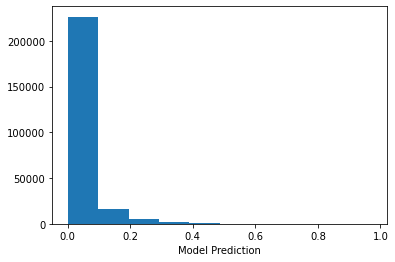

In [382]:
plt.hist(result_df['pred'])
plt.xlabel("Model Prediction")
# plt.yscale('log')
plt.show()


In [137]:
top_k_dude = result_df[result_df.kinase_id.isin(dude_missing_list)].sort_values(by = "pred", ascending = False).head(100)
top_k_surfaceome = result_df[~result_df.kinase_id.isin(dude_missing_list)].sort_values(by = "pred", ascending = False).head(100)

In [141]:
common_hits = set(top_k_surfaceome.drug_id).intersection(top_k_dude.drug_id)
common_hits

{'ZINC01619592',
 'ZINC02047503',
 'ZINC03995884',
 'ZINC04095791',
 'ZINC05615681',
 'ZINC12501465',
 'ZINC20149040',
 'ZINC38141704',
 'ZINC45789132',
 'ZINC45789135'}

In [372]:
result_df[result_df.kinase_id == 'EPHB1'].sort_values(by = 'pred', ascending = False)

,drug_id,kinase_id,pred
17730,ZINC02047503,EPHB1,0.923823
52884,ZINC06716957,EPHB1,0.397012
87336,ZINC19632618,EPHB1,0.297738
163530,ZINC27646816,EPHB1,0.245409
214560,ZINC49034948,EPHB1,0.225105
...,...,...,...
84744,ZINC16052168,EPHB1,0.000000
84798,ZINC16052349,EPHB1,0.000000
84852,ZINC16052519,EPHB1,0.000000
84906,ZINC16052718,EPHB1,0.000000


In [373]:
selected_kinases = [
    "EGFR",
    "TGFBR2",
    "KIT",
    "AKT2",
    "SRC",
    "EPHB1",
    "FLT3",
]

In [432]:
cayman_purchasing[(cayman_purchasing.ZINC_ID == 'ZINC45789132') & (cayman_purchasing.Supplier == "Cayman Chemical")]

,ZINC_ID,Supplier,Supplier_code,Website,Email,Phone,Fax,OrderURL,Unnamed: 8,Unnamed: 9
45069,ZINC45789132,Cayman Chemical,13089,www.caymanchem.com,cayman@caymanchem.com,+1 734 971 3335,+1 734 971 3640,http://www.caymanchem.com/app/template/Product...,1.0,1.0


In [383]:
assays_from_selected_kinases = result_df[result_df.kinase_id.isin(selected_kinases)]

In [374]:
selected_drugs = result_df[result_df.kinase_id.isin(selected_kinases)].sort_values(by = "pred", ascending = False).drug_id.unique()

In [375]:
selected_assays = result_df[result_df.kinase_id.isin(selected_kinases) & result_df.drug_id.isin(selected_drugs)].sort_values(by = "pred", ascending = False)

In [376]:
thresh_array = result_df[result_df.kinase_id.isin(selected_kinases) & (result_df.pred >= 0.5)]

In [377]:
vc = thresh_array.drug_id.value_counts()
mc = thresh_array.groupby('drug_id').pred.mean()

In [378]:
drug_sort_df = pd.DataFrame({'drug': thresh_array.drug_id})
drug_sort_df = pd.merge(drug_sort_df, pd.DataFrame(vc).reset_index(), left_on = 'drug', right_on = 'index')
drug_sort_df = pd.merge(drug_sort_df, pd.DataFrame(mc).reset_index(), left_on = 'drug', right_on = 'drug_id')
drug_sort_df = drug_sort_df.sort_values(by = ['drug_id_x', 'pred'], ascending = False).drop_duplicates()[['drug', 'drug_id_x', 'pred']].reset_index(drop = True)
drug_sort_df.columns  = ['drug_id', 'count', 'mean_pred']

In [402]:
drug_sort_purchasing = pd.merge(drug_sort_df, cayman_purchasing[cayman_purchasing['Supplier'] == 'Cayman Chemical'], left_on = 'drug_id', right_on = 'ZINC_ID').drop_duplicates('Supplier_code')
drug_sort_purchasing[drug_sort_purchasing.drug_id == 'ZINC00116937']

,drug_id,count,mean_pred,ZINC_ID,Supplier,Supplier_code,Website,Email,Phone,Fax,OrderURL,Unnamed: 8,Unnamed: 9
12,ZINC00116937,3,0.788303,ZINC00116937,Cayman Chemical,10010244,www.caymanchem.com,cayman@caymanchem.com,+1 734 971 3335,+1 734 971 3640,http://www.caymanchem.com/app/template/Product...,1.0,1.0


In [391]:
for _, r in assays_from_selected_kinases[assays_from_selected_kinases['drug_id'].isin(drug_sort_purchasing.drug_id) & (assays_from_selected_kinases.pred >= 0.5) ].iterrows():
    print(f'{r.kinase_id},{r.drug_id},{r.pred}')

KIT,ZINC06718813,0.9729451537132263
EGFR,ZINC19632614,0.9709916710853577
FLT3,ZINC06718813,0.9651068449020386
FLT3,ZINC01493878,0.9465140104293823
KIT,ZINC01493878,0.926544725894928
EPHB1,ZINC02047503,0.9238232374191284
EGFR,ZINC00116937,0.9229017496109009
EGFR,ZINC22067501,0.9174197316169739
EGFR,ZINC00602192,0.9170599579811096
EGFR,ZINC00009851,0.9035815596580505
KIT,ZINC19632618,0.8544597029685974
EGFR,ZINC13816313,0.8534308075904846
TGFBR2,ZINC01619592,0.8534120321273804
FLT3,ZINC00008082,0.8431758880615234
FLT3,ZINC22449469,0.8425177335739136
TGFBR2,ZINC38141704,0.8327192664146423
KIT,ZINC00008082,0.8326796889305115
FLT3,ZINC22067501,0.8285077810287476
FLT3,ZINC03964325,0.826521098613739
KIT,ZINC22067501,0.8233504891395569
FLT3,ZINC19632618,0.8211500644683838
KIT,ZINC03964325,0.8184364438056946
KIT,ZINC22449469,0.8117204904556274
EGFR,ZINC01493878,0.7871772646903992
KIT,ZINC00602192,0.7839434742927551
FLT3,ZINC00602192,0.7783971428871155
FLT3,ZINC00009851,0.7764930129051208
KIT,ZI

In [352]:
cayman_purchasing[cayman_purchasing["ZINC_ID"] == drug_sort_df.drug_id[1]]

,ZINC_ID,Supplier,Supplier_code,Website,Email,Phone,Fax,OrderURL,Unnamed: 8,Unnamed: 9
26339,ZINC05615681,PubChem,16078863,pubchem.ncbi.nlm.nih.gov,email,phone,fax,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,1.0,0.0
26340,ZINC05615681,ChEMBL12,CHEMBL290084,www.ebi.ac.uk,no email,no phone,no fax,http://www.ebi.ac.uk/chembldb/index.php/compou...,1.0,0.0
26341,ZINC05615681,PubChem,44348997,pubchem.ncbi.nlm.nih.gov,email,phone,fax,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,1.0,0.0
26342,ZINC05615681,Calbiochem,569397,www.calbiochem.com,customer.service@emdbioscience,+1 800 854 3417,+1 800 776 0999,mailto:customer.service@emdbiosciences.com?SUB...,1.0,1.0
26343,ZINC05615681,PubChem,9804568,pubchem.ncbi.nlm.nih.gov,email,phone,fax,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,1.0,0.0
26344,ZINC05615681,PubChem,358479,pubchem.ncbi.nlm.nih.gov,email,phone,fax,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,1.0,0.0
26345,ZINC05615681,Molport,MolPort-003-983-808,www.molport.com,sales@molport.com,+371 67790398,+371 67801123,http://www.molport.com/buy-chemicals/molecule-...,1.0,5.0
26346,ZINC05615681,PubChem,15939267,pubchem.ncbi.nlm.nih.gov,email,phone,fax,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,1.0,0.0
26347,ZINC05615681,ChEMBL12,CHEMBL487021,www.ebi.ac.uk,no email,no phone,no fax,http://www.ebi.ac.uk/chembldb/index.php/compou...,1.0,0.0
26348,ZINC05615681,ChEMBL11,CHEMBL487021,www.ebi.ac.uk,no email,no phone,no fax,http://www.ebi.ac.uk/chembldb/index.php/compou...,1.0,0.0


In [350]:
cayman_purchasing[cayman_purchasing["ZINC_ID"] == drug_sort_df.drug_id[0]].OrderURL.values

array(['http://cgi.www.apolloscientific.co.uk/cgi-bin/www.apolloscientific.co.uk/csvread.pl?database=db2&search=BIS0504',
       'http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=358479',
       'http://www.ncbi.nlm.nih.gov/pccompound?term=5311103',
       'http://www.ebi.ac.uk/chembldb/index.php/compound/inspect/CHEMBL1537489',
       'http://www.ncbi.nlm.nih.gov/pccompound?term=MLS000028832-01',
       'https://app.collaborativedrug.com/public/structures/156271',
       'http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=49831000',
       'http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=5459111',
       'http://academics.emolecules.com/cgi-bin/rene/list_search.cgi?datatype=emol_id&SEARCH=SEARCH&list=29914548',
       'http://www.caymanchem.com/app/template/Product.vm/catalog/81590',
       'http://www.ebi.ac.uk/chembldb/index.php/compound/inspect/CHEMBL1537489',
       'http://www.bindingdb.org/bind/chemsearch/marvin/MolStructure.jsp?monomerid=32337'],
      dtype

In [328]:
drug_sort_df

,drug_id,count,mean_pred
44,ZINC04095791,4,0.603902
48,ZINC05615681,4,0.603902
57,ZINC12501465,4,0.603902
89,ZINC20149040,4,0.603902
19,ZINC01493878,3,0.886745
54,ZINC06718813,3,0.877396
93,ZINC22067501,3,0.856426
82,ZINC19632614,3,0.835758
10,ZINC00602192,3,0.826467
25,ZINC01649340,3,0.826467


In [296]:
selected_assays[selected_assays['kinase_id'] == 'SRC'].head(10)

,drug_id,kinase_id,pred
17761,ZINC02047503,SRC,0.744094
35473,ZINC03995884,SRC,0.515644
14737,ZINC01619592,SRC,0.515644
179761,ZINC38141704,SRC,0.503141
212539,ZINC45789135,SRC,0.463320
212485,ZINC45789132,SRC,0.463320
246289,ZINC71746293,SRC,0.456907
246343,ZINC71746294,SRC,0.456907
246235,ZINC71746292,SRC,0.456907
246397,ZINC71746295,SRC,0.456907


In [297]:
result_df[result_df.kinase_id == 'SRC'].sort_values(by = 'pred', ascending = False).head(10)

,drug_id,kinase_id,pred
17761,ZINC02047503,SRC,0.744094
14737,ZINC01619592,SRC,0.515644
35473,ZINC03995884,SRC,0.515644
179761,ZINC38141704,SRC,0.503141
9607,ZINC00915717,SRC,0.484540
18733,ZINC02483738,SRC,0.484540
212539,ZINC45789135,SRC,0.463320
212485,ZINC45789132,SRC,0.463320
246397,ZINC71746295,SRC,0.456907
246235,ZINC71746292,SRC,0.456907


In [281]:
selected_assays

,drug_id,kinase_id,pred
52956,ZINC06718813,KIT,0.972945
87275,ZINC19632614,EGFR,0.970992
52950,ZINC06718813,FLT3,0.965107
11316,ZINC01493878,FLT3,0.946514
11322,ZINC01493878,KIT,0.926545
...,...,...,...
174726,ZINC34048998,KIT,0.515007
174720,ZINC34048998,FLT3,0.508870
179761,ZINC38141704,SRC,0.503141
212539,ZINC45789135,SRC,0.463320


In [282]:
selected_assays.head(100).kinase_id.value_counts()

EGFR      17
KIT       16
FLT3      16
TGFBR2    10
AKT2      10
SRC        6
Name: kinase_id, dtype: int64

In [266]:
selected_assays.drug_id.value_counts()

ZINC27645129    6
ZINC00116937    5
ZINC00009851    4
ZINC00603769    4
ZINC34048998    4
ZINC00008082    4
ZINC19632618    4
ZINC02047503    4
ZINC01649340    4
ZINC00602192    4
ZINC22067501    4
ZINC13677843    4
ZINC03963016    4
ZINC45789135    3
ZINC71746292    3
ZINC71746294    3
ZINC71746293    3
ZINC71746295    3
ZINC06718813    3
ZINC45789132    3
ZINC03964325    3
ZINC19632614    3
ZINC22449469    3
ZINC03995884    3
ZINC01619592    3
ZINC13816313    3
ZINC01493878    3
ZINC38141704    3
Name: drug_id, dtype: int64

In [239]:
purchasing_subset = cayman_purchasing[(cayman_purchasing["Supplier"] == "Cayman Chemical") & cayman_purchasing["ZINC_ID"].isin(selected_assays.drug_id.value_counts().index)]
purchasing_subset = purchasing_subset[["ZINC_ID", "Supplier_code", "OrderURL"]]